## aRchaic on Gosling ancient + controls data

We apply aRchaic on 47 ancient and 7 control samples from Anna Gosling in Anna Di Rienzo's lab. The metadata corresponding to this data are available [here](data/Gosling_metadata). 
Our primary interest in using this data were to 

- see if the controls have any contamination due to ancients
- how does this data compare to other ancients (Sherpa data)
- how do the ancients and the control samples compare with available modern data (HGDP, 1000 Genomes)
- What damage patterns do we see and are there any novel structure we detect?

In [5]:
options(warn=-1)
library(aRchaic)
library(CountClust)
library(maptpx)
library(grid)
library(gridBase)

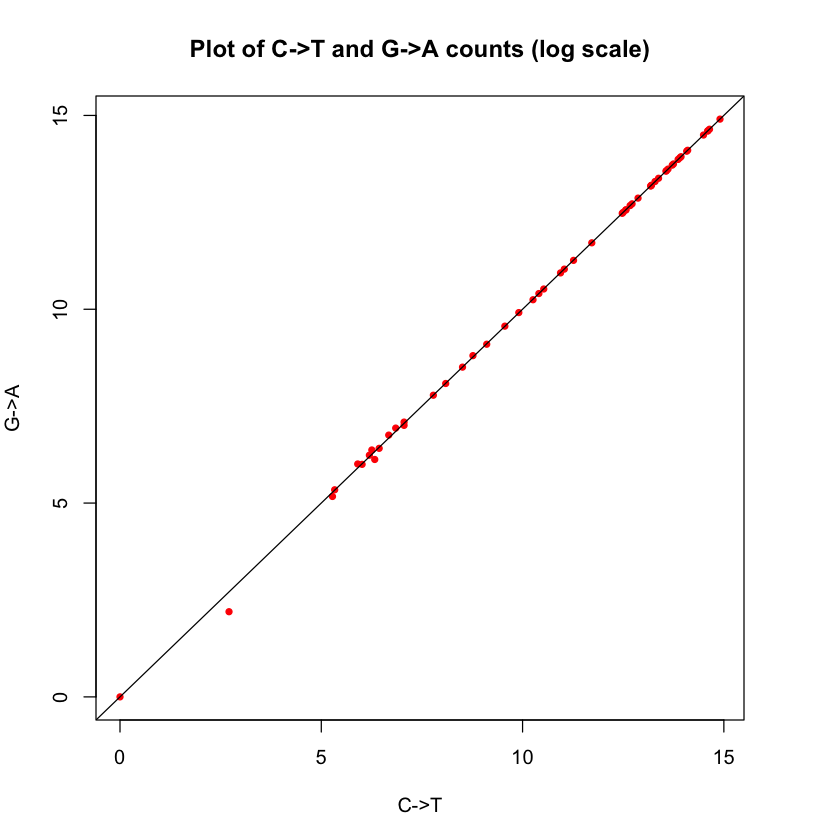

In [2]:
## Load the signature counts data 
signature_counts <- get(load("../processed_data/annagosling2016-counts-table.rda"))

## validate if the strand information matters or not
validation_check <- aRchaic::club_signature_validation_plot(signature_counts, log=TRUE)

In [4]:
##  club the signature counts from the two strands 
clubbed_counts <- aRchaic::club_signature_counts(signature_counts)
sum(clubbed_counts[28, ]) ## this sample has only one read 

[1] 1

In [6]:
## filter out this rogue sample
clubbed_counts <- clubbed_counts[-28,];

### aRchaic without position information

We first ignore the position information in the signatures and carry out the clustering based on only the mutations and the flanking bases.

In [7]:
## filter the counts out with locations 
filtered_counts <- filter_signatures_wo_location(clubbed_counts);

In [8]:
## Defining the signatures to be fed into the independent maptpx model

signature_set <- colnames(filtered_counts)
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]])))
new_sig_split <- matrix(0, dim(sig_split)[1], 5);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
   temp <- as.factor(new_sig_split[,k])
   mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

signatures <- mat;


In [ ]:
## topics_clus <- maptpx::topics(filtered_counts, K=3, type="independent", tol=10, signatures = signatures)

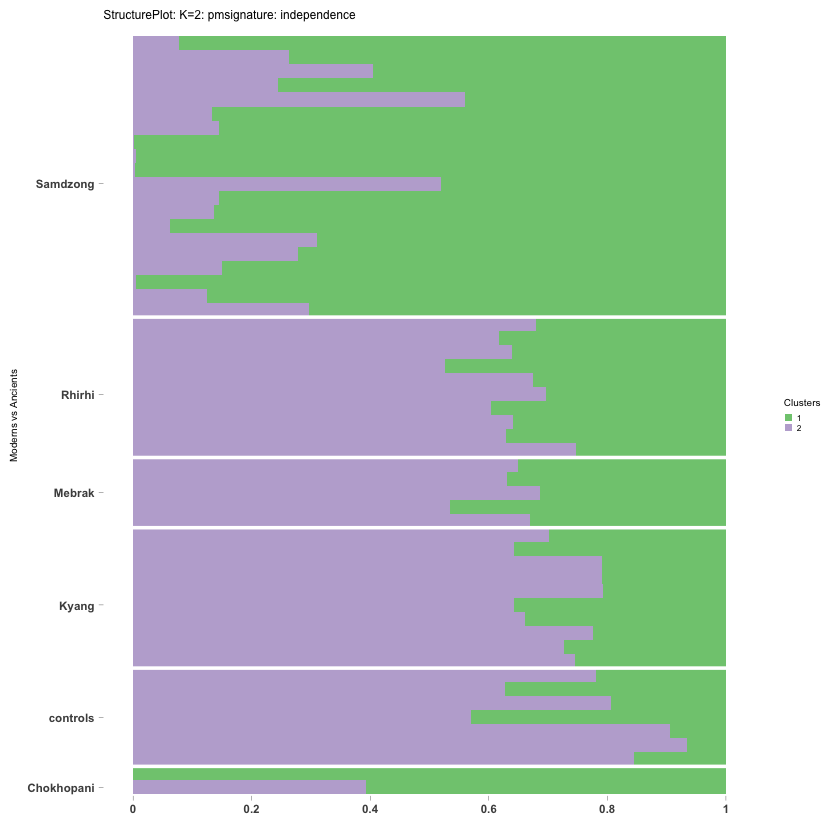

In [32]:
## Visualize the membership probabilities in different clusters 

topics_clus <-  get(load("../rda/topicmodel_independent_K_2.rda"))

omega <- topics_clus$omega

names <- rownames(filtered_counts);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

labs <- character();
labs <- rep("ancient", dim(filtered_counts)[1])
labs[control_indices] <- "controls"

ancient_names = names[- control_indices]
pop_names_1 <- as.factor(substring(ancient_names, 8, 8))
levels(pop_names_1) = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong")
labs[-control_indices] <- as.character(pop_names_1)


annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs)
)

par(mfrow=c(1,1))
CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = RColorBrewer::brewer.pal(8, "Accent"),
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],": pmsignature: independence"),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

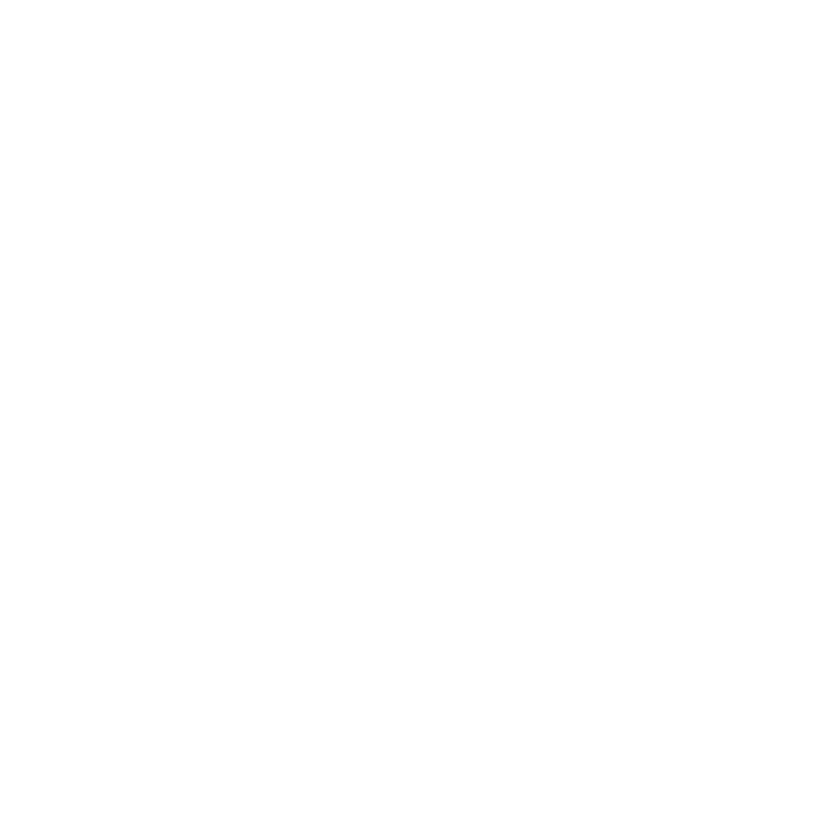

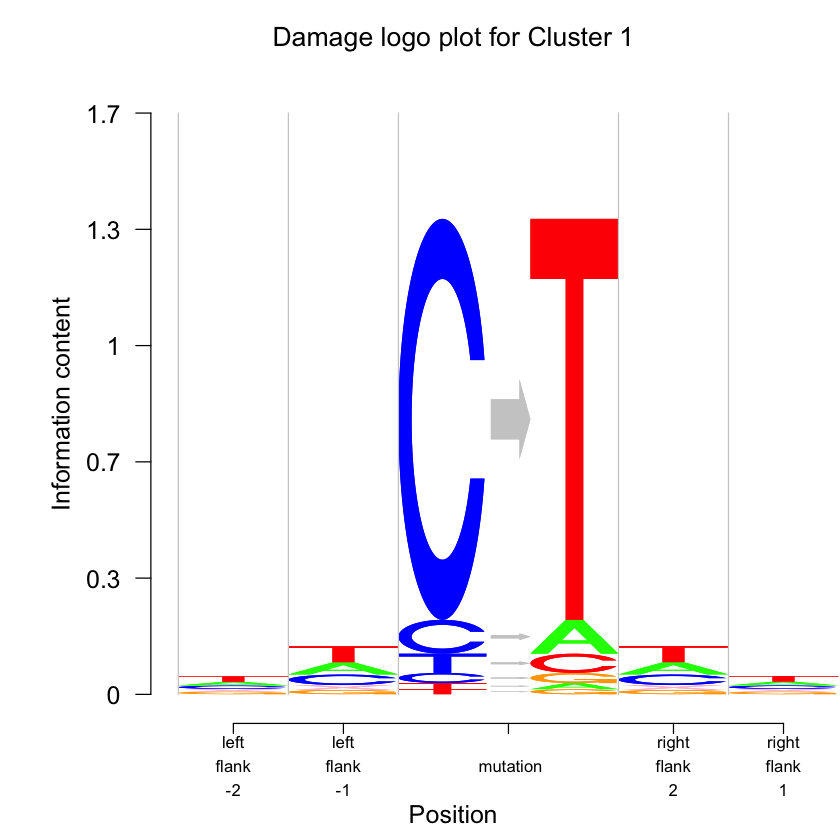

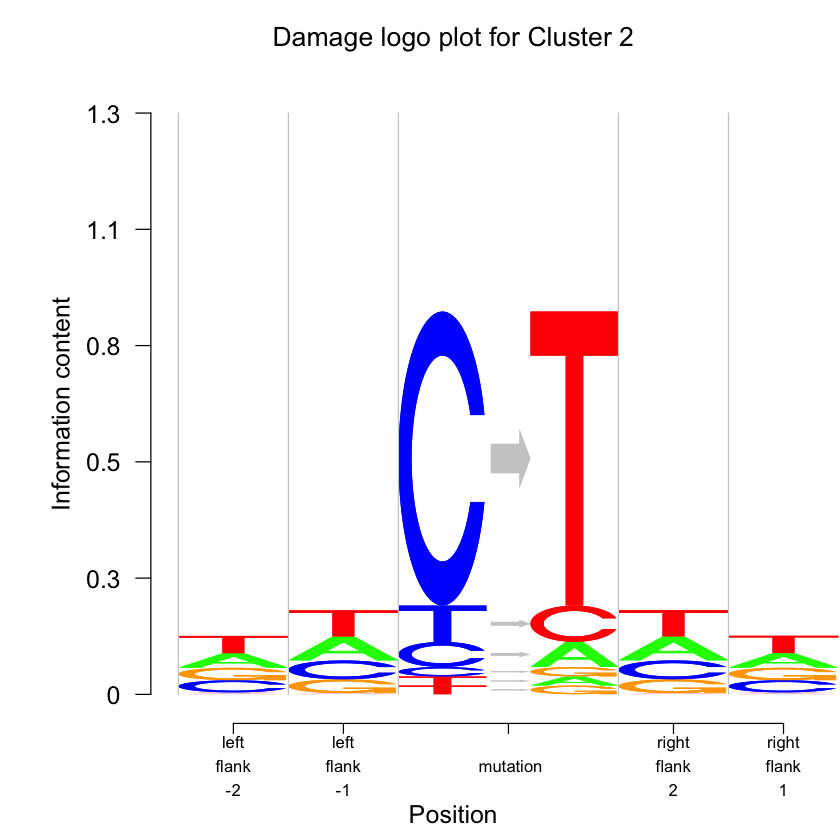

In [11]:
## Visualizing the clusters using logo plots 
plot.new()
damageLogo(topics_clus$theta)

In [14]:
## Read in the modern data

modern_data_clubbed <- get(load("../processed_data/1000Gmoderns-clubbed_counts-table.rda"));
pooled_names <- intersect(colnames(clubbed_counts), colnames(modern_data_clubbed))

In [15]:
## Using position information for clustering data

filtered_gossling <- clubbed_counts[, match(pooled_names, colnames(clubbed_counts))]
filtered_gossling_2 <- filter_signatures_by_location(filtered_gossling, max_pos=20, flanking_bases = 2)

In [16]:
filtered_moderns <- modern_data_clubbed[, match(pooled_names, colnames(modern_data_clubbed))]
filtered_moderns_2 <- filter_signatures_by_location(filtered_moderns, max_pos=20, flanking_bases = 2)


In [17]:
names <- rownames(filtered_gossling_2);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

labs <- character();
labs <- rep("ancient", dim(filtered_gossling_2)[1])
labs[control_indices] <- "controls"
labs <- c(labs, rep("1000g", dim(filtered_moderns_2)[1]))

indices <- which(labs == "ancient")

gossling_ancients <- filtered_gossling_2[indices, ]

In [19]:
pooled_data <- rbind(filtered_gossling_2, filtered_moderns_2)
dim(pooled_data)

[1]   553 30716

In [21]:
## Building signatures to be fed to the independent maptpx model

signature_set <- colnames(pooled_data)
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]][1:8])))
new_sig_split <- matrix(0, dim(sig_split)[1], 5);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

pos <- t(sapply(1:length(signature_set), function(x)
{
  y = strsplit(signature_set[x], "")[[1]]
  return(paste(y[10:length(y)], collapse=""))
}))



mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
  temp <- as.factor(new_sig_split[,k])
  mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

pos <- as.numeric(pos)
pos <- pos - min(pos)
pos <- factor(pos, levels = 0:20)

signatures <- mat;
signature_pos <- cbind.data.frame(signatures, pos)

In [24]:
out <- topics(pooled_data, K=2, tol=100, model="independent", signatures = signature_pos)
#save(out, file="../processed_data/maptpx-runs/gosling2016-1000g-maptpx-independent-K-2.rda")



Estimating on a 553 document collection.
Fitting the 2 topic model.
log posterior increase: 1891317.3, 578178.2, 40001, 16045.9, 6931, 6587.7, 5761.5, 5771.5, 4796.5, 3614.9, 3130.8, 2569.1, 2328.6, 1727.7, 1389.4, 1080.7, 631.2, 408.5, 428.2, 303.7, 197.7, 120.4, 119.6, done.


In [25]:
save(out, file="../processed_data/maptpx-runs/gosling2016-1000g-maptpx-independent-K-2.rda")

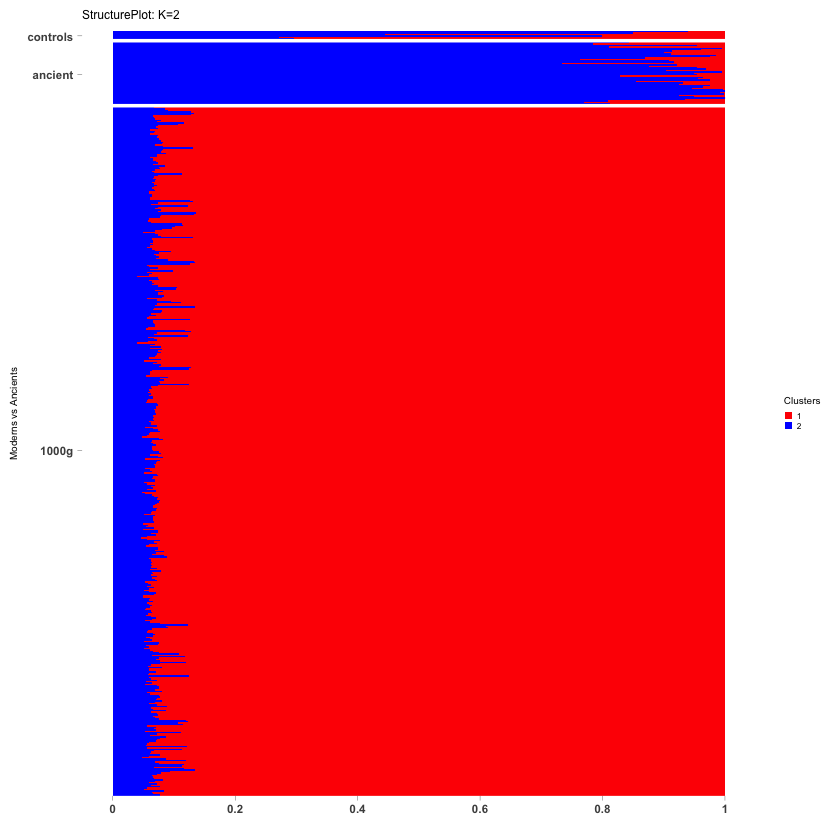

In [26]:
out <- get(load("../processed_data/maptpx-runs/gosling2016-1000g-maptpx-independent-K-2.rda"))

omega <- out$omega

cols1 <- c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
           "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
           "brown4","darkorchid","magenta","yellow", "azure1","azure4")

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs)
)

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = cols1,
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],""),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))


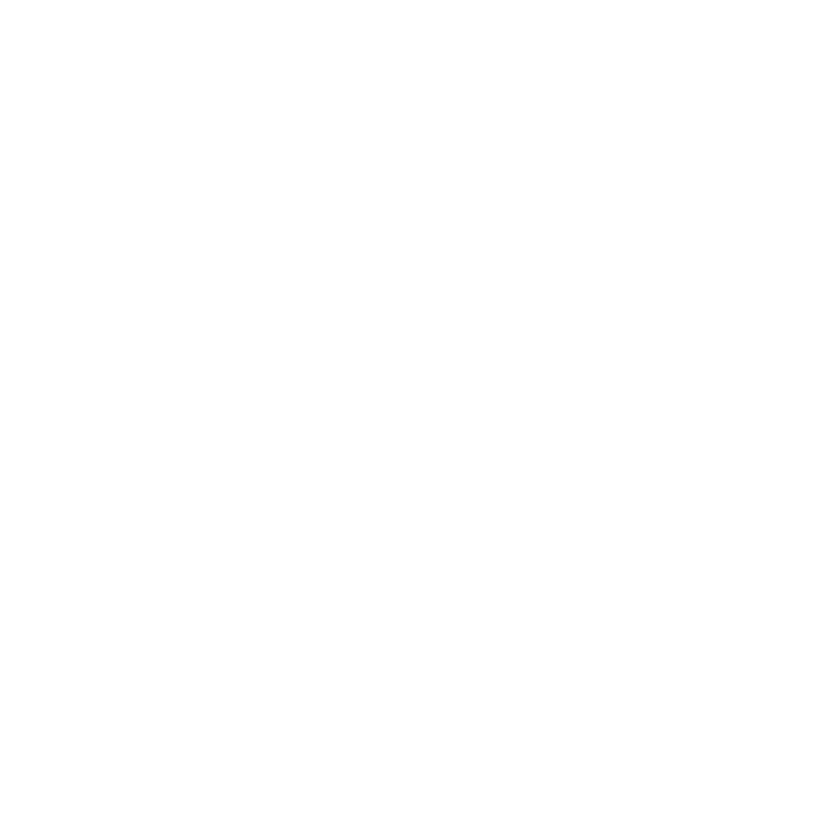

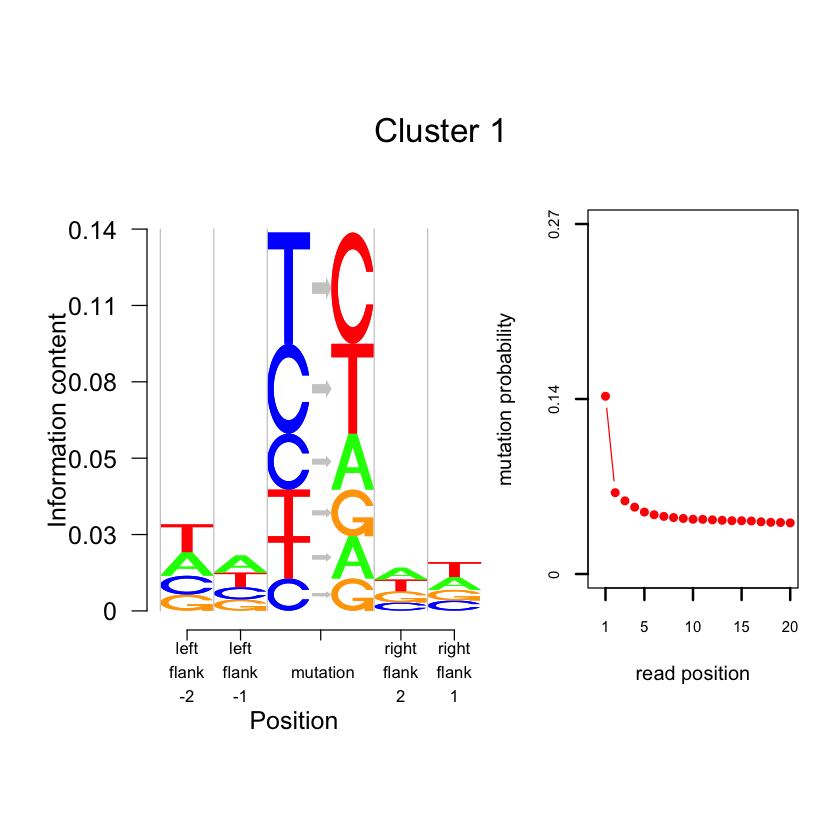

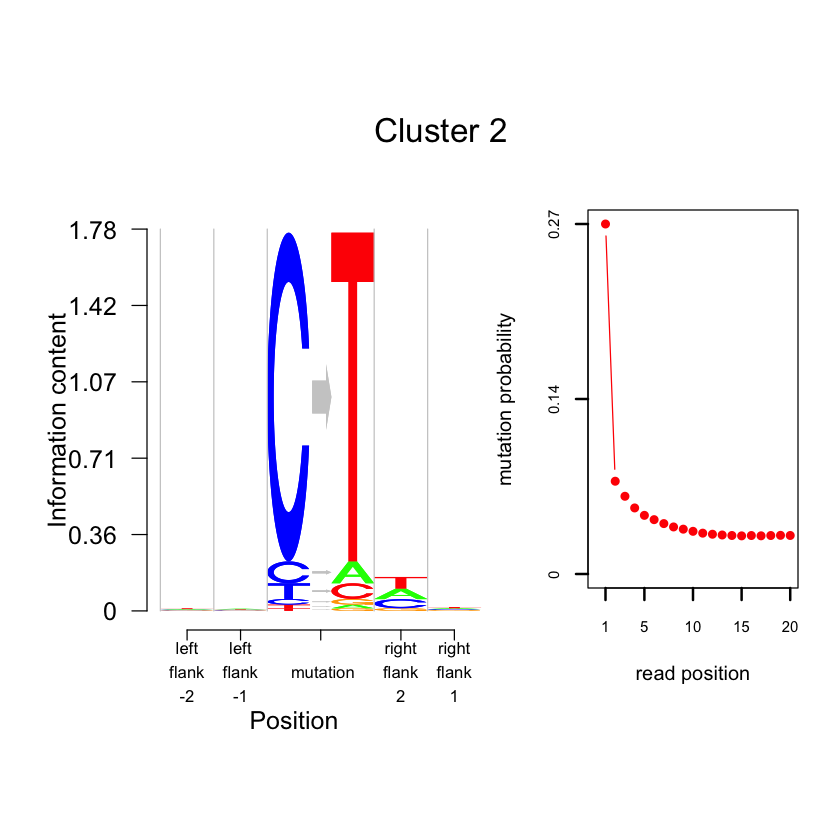

In [30]:
plot.new()
aRchaic::damageLogo_pos(out$theta)

In [33]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridBase_0.4-7   maptpx_1.9-3     CountClust_0.1.2 ggplot2_2.2.1   
[5] aRchaic_0.99.0  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8         RColorBrewer_1.1-2  plyr_1.8.4         
 [4] tools_3.3.1         boot_1.3-18         digest_0.6.11      
 [7] uuid_0.1-2          nlme_3.1-128        jsonlite_1.2       
[10] evaluate_0.10       tibble_1.2          gtable_0.2.0       
[13] lattice_0.20-34     mgcv_1.8-16         Matrix_1.2-7.1     
[16] IRdisplay_0.4.4     parallel_3.3.1      IRkernel_0.7.1     
[19] gridExtra_2.2.1     cluster_2.0.5       repr_0.10          
[22] stringr_1.1.0       gtools_3.5.0        stats4_3.3.1       
[25] nnet_7.3-12    